<a href="https://colab.research.google.com/github/suruchi1997/yolov7/blob/main/TL_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# Data Preprocess

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [3]:
# Dividing into val and test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [4]:
#Load data directly from disk
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

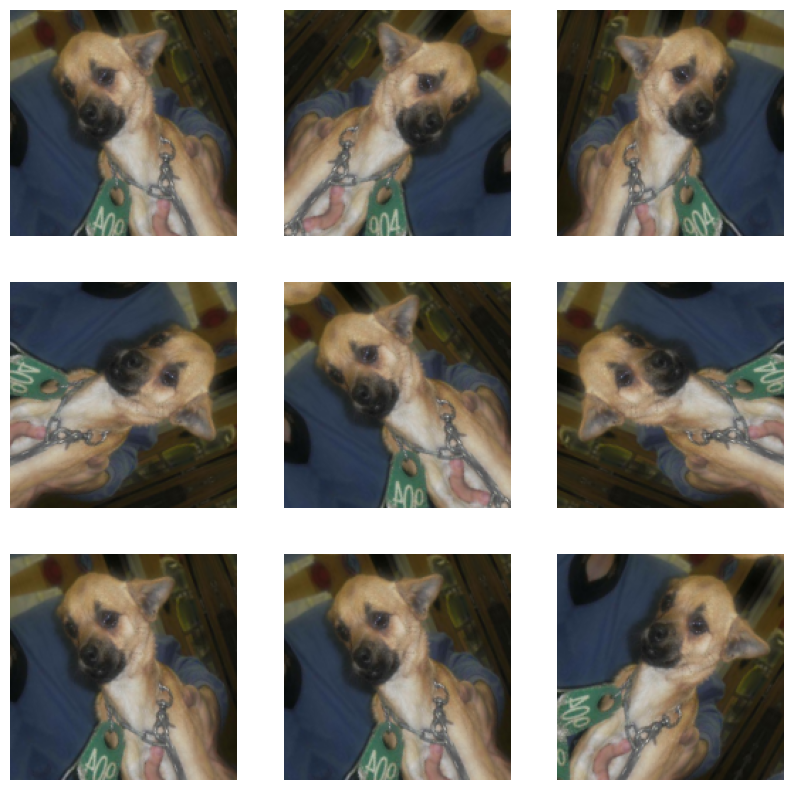

In [5]:
# data augmentation , since dataset is small
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [6]:
# Rescaling the data according to the model we are utilizing 
preprocess_input = tf.keras.applications.resnet.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [7]:
# Using Resnet for  feature extraction , include_top=false will not include dense layers for classification
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


171446536/171446536 [==============================] - 1s 0us/step


In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# feeze convolution layers of base model
base_model.trainable = False

# summarizing base_model
base_model.summary()



(32, 5, 5, 2048)
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_

In [9]:
#clasification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#using training = False as model has batchnormalization layer
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 2048)
(32, 1)


In [10]:
#compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [11]:
# trainable variables
len(model.trainable_variables)

#evaluation after 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 7s 110ms/step - loss: 1.5500 - accuracy: 0.3342
initial loss: 1.55
initial accuracy: 0.33


In [12]:
# fitting train_dataset
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 17s 156ms/step - loss: 1.0098 - accuracy: 0.4920 - val_loss: 0.6582 - val_accuracy: 0.6597
Epoch 2/10
63/63 [==============================] - 10s 150ms/step - loss: 0.5754 - accuracy: 0.7050 - val_loss: 0.3564 - val_accuracy: 0.8478
Epoch 3/10
63/63 [==============================] - 10s 151ms/step - loss: 0.3861 - accuracy: 0.8110 - val_loss: 0.2330 - val_accuracy: 0.9158
Epoch 4/10
63/63 [==============================] - 10s 156ms/step - loss: 0.3014 - accuracy: 0.8610 - val_loss: 0.1791 - val_accuracy: 0.9418
Epoch 5/10
63/63 [==============================] - 12s 188ms/step - loss: 0.2854 - accuracy: 0.8720 - val_loss: 0.1564 - val_accuracy: 0.9530
Epoch 6/10
63/63 [==============================] - 11s 174ms/step - loss: 0.2382 - accuracy: 0.8965 - val_loss: 0.1257 - val_accuracy: 0.9691
Epoch 7/10
63/63 [==============================] - 10s 149ms/step - loss: 0.2067 - accuracy: 0.9120 - val_loss: 0.1054 - val_accuracy: 0.9715

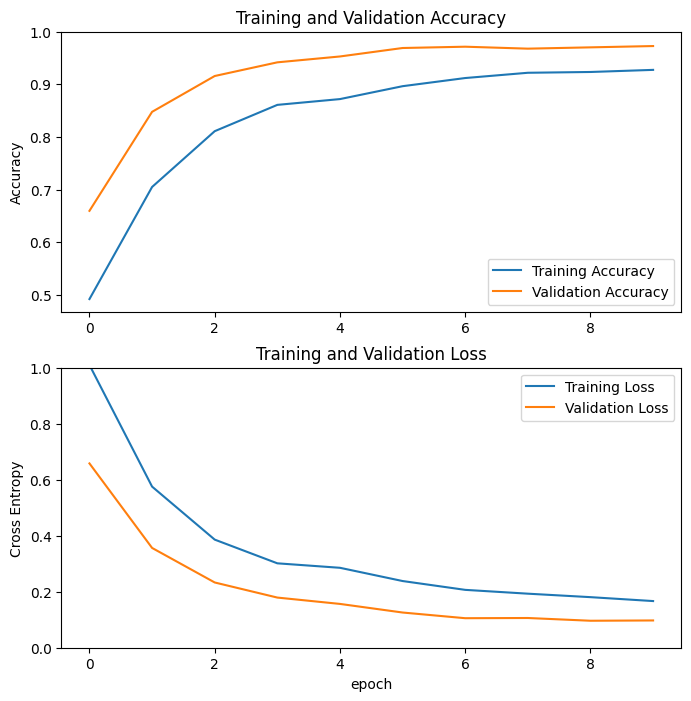

In [13]:
#learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
#fine tune
#unfreeze top layers
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
# model summary
model.summary()

Number of layers in the base model:  345
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling

Epoch 10/20
63/63 [==============================] - 64s 328ms/step - loss: 0.1398 - accuracy: 0.9490 - val_loss: 0.0527 - val_accuracy: 0.9864
Epoch 11/20
63/63 [==============================] - 19s 292ms/step - loss: 0.0821 - accuracy: 0.9650 - val_loss: 0.0910 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 18s 286ms/step - loss: 0.0593 - accuracy: 0.9735 - val_loss: 0.0824 - val_accuracy: 0.9703
Epoch 13/20
63/63 [==============================] - 18s 286ms/step - loss: 0.0413 - accuracy: 0.9830 - val_loss: 0.0387 - val_accuracy: 0.9901
Epoch 14/20
63/63 [==============================] - 18s 287ms/step - loss: 0.0395 - accuracy: 0.9875 - val_loss: 0.0589 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 18s 288ms/step - loss: 0.0283 - accuracy: 0.9885 - val_loss: 0.0775 - val_accuracy: 0.9752
Epoch 16/20
63/63 [==============================] - 18s 287ms/step - loss: 0.0290 - accuracy: 0.9885 - val_loss: 0.0357 - val_accuracy:

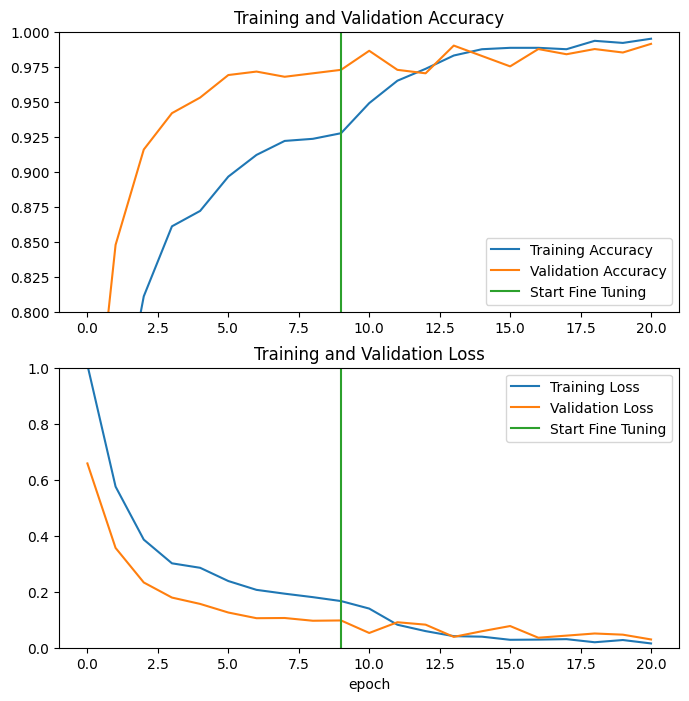

In [15]:
len(model.trainable_variables)

# continue training the model

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# compute loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
# plot the curves

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()